In [1]:
import pandas as pd
from forex_python.converter import CurrencyRates
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score
from sklearn.feature_selection import f_regression, SelectKBest
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
df = pd.read_csv('task2.csv')

df = df.drop_duplicates()

df = df.dropna()

df

,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_Currency,Remote_Ratio,Company_Size
0,2024,Senior-Level,Full-Time,AI Engineer,90000,USD,0,Large
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,USD,0,Medium
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,USD,0,Medium
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,USD,0,Medium
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,USD,0,Medium
...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,USD,100,Large
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,USD,100,Large
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,USD,100,S
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,USD,100,Large


In [3]:
currency_counts = df['Salary_Currency'].value_counts()
print("before:")
currency_counts

before:


Salary_Currency
USD    7499
GBP     410
EUR     339
INR      52
CAD      48
AUD      12
PLN       7
CHF       6
SGD       6
JPY       4
BRL       4
DKK       3
HUF       3
TRY       3
NOK       2
THB       2
ZAR       1
HKD       1
ILS       1
PHP       1
NZD       1
MXN       1
CLP       1
Name: count, dtype: int64

In [4]:
valid_currencies = currency_counts[currency_counts >= 10].index
df_filtered = df[df['Salary_Currency'].isin(valid_currencies)]

print("after:")
df_filtered['Salary_Currency'].value_counts()

after:


Salary_Currency
USD    7499
GBP     410
EUR     339
INR      52
CAD      48
AUD      12
Name: count, dtype: int64

In [5]:
df_filtered

,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_Currency,Remote_Ratio,Company_Size
0,2024,Senior-Level,Full-Time,AI Engineer,90000,USD,0,Large
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,USD,0,Medium
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,USD,0,Medium
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,USD,0,Medium
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,USD,0,Medium
...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,USD,100,Large
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,USD,100,Large
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,USD,100,S
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,USD,100,Large


In [6]:
currencies = df_filtered['Salary_Currency'].unique()
conversion_rates = {i:{} for i in currencies}

c = CurrencyRates()

for currency in currencies:
    try:
        for year in range(2020,2025):
            conversion_rates[currency][year] = c.get_rate(currency, 'USD', datetime(year, 1, 1))
    except Exception as e:
        print(f"Error fetching conversion rate for {currency}: {e}")

conversion_rates

{'USD': {2020: 1.0, 2021: 1.0, 2022: 1.0, 2023: 1.0, 2024: 1.0},
 'EUR': {2020: 1.1234, 2021: 1.2271, 2022: 1.1326, 2023: 1.0666, 2024: 1.105},
 'GBP': {2020: 1.3204043253408555,
  2021: 1.3649155200605096,
  2022: 1.347884038653782,
  2023: 1.2025751750419988,
  2024: 1.2715033657442034},
 'CAD': {2020: 0.7695574736265242,
  2021: 0.7849421096398644,
  2022: 0.7869103036198152,
  2023: 0.7386426592797785,
  2024: 0.75467832263352},
 'AUD': {2020: 0.7023444826508284,
  2021: 0.7719552088575743,
  2022: 0.7253282100544348,
  2023: 0.6796660931625566,
  2024: 0.6794564348521183},
 'INR': {2020: 0.014009752204222629,
  2021: 0.013686071346914195,
  2022: 0.013446643206868876,
  2023: 0.01209694797609191,
  2024: 0.012023350325609736}}

In [7]:
def convert_to_usd(row):
    amount = row['Salary']
    currency = row['Salary_Currency']
    Work_Year=row['Work_Year']
    try:
        return amount * conversion_rates[currency][Work_Year]
    except KeyError:
        print(f"Conversion rate for {currency} not found.")
        return None

df_filtered['Salary_in_USD'] = df_filtered.apply(convert_to_usd, axis=1)

df_filtered = df_filtered.dropna(subset=['Salary_in_USD'])

df_filtered

C:\Users\HP\AppData\Local\Temp\ipykernel_11528\1277980358.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Salary_in_USD'] = df_filtered.apply(convert_to_usd, axis=1)


,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_Currency,Remote_Ratio,Company_Size,Salary_in_USD
0,2024,Senior-Level,Full-Time,AI Engineer,90000,USD,0,Large,90000.000000
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,USD,0,Medium,180500.000000
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,USD,0,Medium,96200.000000
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,USD,0,Medium,235000.000000
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,USD,0,Medium,175000.000000
...,...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,USD,100,Large,412000.000000
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,USD,100,Large,151000.000000
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,USD,100,S,105000.000000
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,USD,100,Large,100000.000000


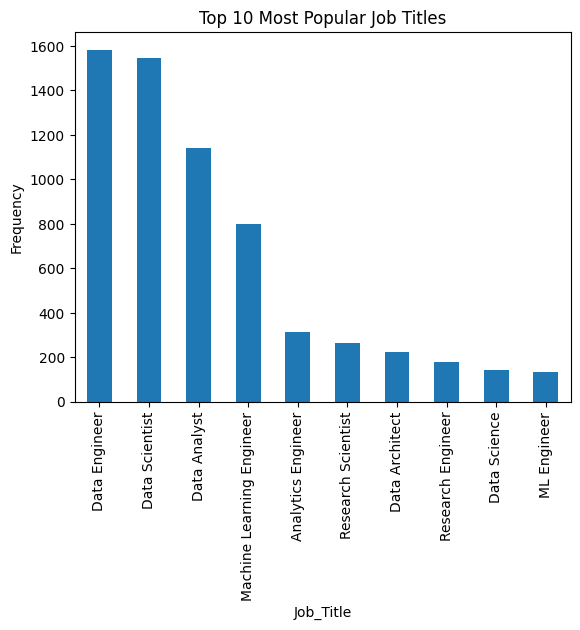

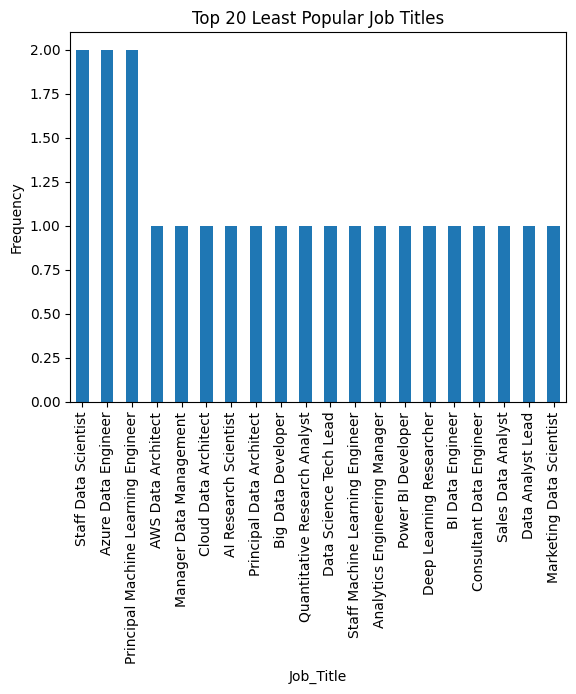

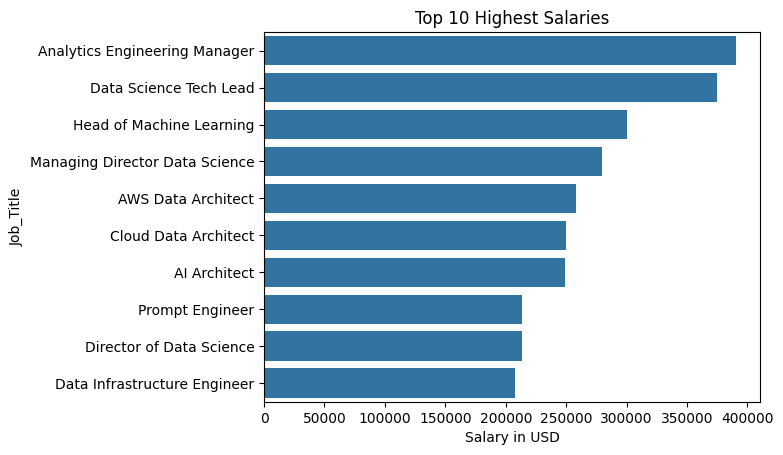

Job_Title
Analytics Engineering Manager      1
Data Science Tech Lead             1
Head of Machine Learning           7
Managing Director Data Science     2
AWS Data Architect                 1
Cloud Data Architect               1
AI Architect                      18
Prompt Engineer                   13
Director of Data Science          31
Data Infrastructure Engineer      16
Name: count, dtype: int64

In [8]:
top_titles = df_filtered['Job_Title'].value_counts().head(10)
top_titles.plot(kind='bar')
plt.title('Top 10 Most Popular Job Titles')
plt.ylabel('Frequency')
plt.show()

top_titles = df_filtered['Job_Title'].value_counts().tail(20)
top_titles.plot(kind='bar')
plt.title('Top 20 Least Popular Job Titles')
plt.ylabel('Frequency')
plt.show()

top_salaries = pd.DataFrame(df_filtered.groupby(['Job_Title'])['Salary_in_USD'].mean().nlargest(10))
top_salaries['Job_Title']=top_salaries.index
sns.barplot(x='Salary_in_USD', y='Job_Title', data=top_salaries)
plt.title('Top 10 Highest Salaries')
plt.xlabel('Salary in USD')
plt.show()

df_filtered['Job_Title'].value_counts()[top_salaries['Job_Title']]

In [9]:
job_salary_mean=pd.DataFrame(df_filtered.groupby(['Job_Title'])['Salary_in_USD'].mean())
job_salary_mean['Job_Title']=job_salary_mean.index
def salary_times_frequency(row):
    salary = row['Salary_in_USD']
    frequency = df_filtered['Job_Title'].value_counts()[row['Job_Title']]
    try:
        return salary * frequency
    except KeyError:
        print(f"Conversion rate for {currency} not found.")
        return None

job_salary_mean.apply(salary_times_frequency,axis=1).nlargest(10)

Job_Title
Data Scientist               2.319952e+08
Data Engineer                2.316654e+08
Machine Learning Engineer    1.428174e+08
Data Analyst                 1.240895e+08
Analytics Engineer           5.082692e+07
Research Scientist           5.046809e+07
Data Architect               3.677814e+07
Research Engineer            3.234211e+07
ML Engineer                  2.685784e+07
Data Science                 2.271944e+07
dtype: float64

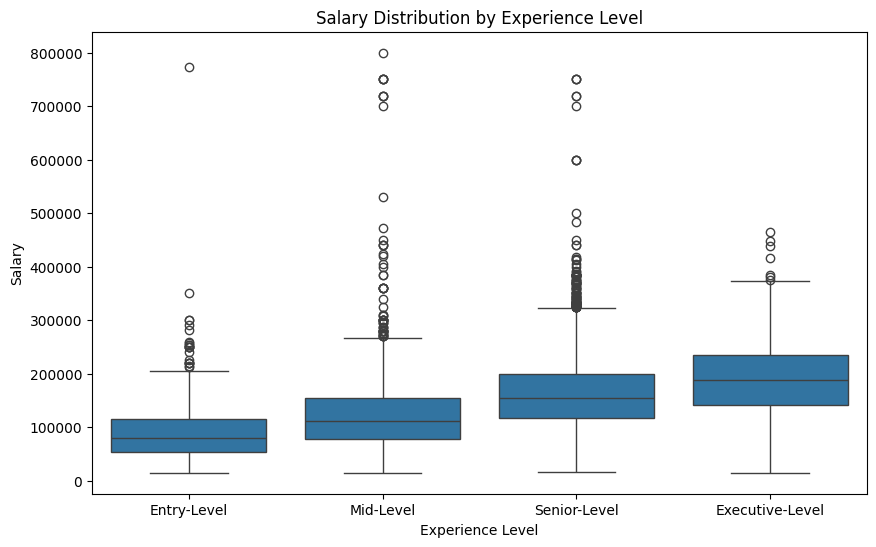

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Experience_Level', y='Salary_in_USD', data=df_filtered, order=['Entry-Level', 'Mid-Level', 'Senior-Level', 'Executive-Level'])
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.show()

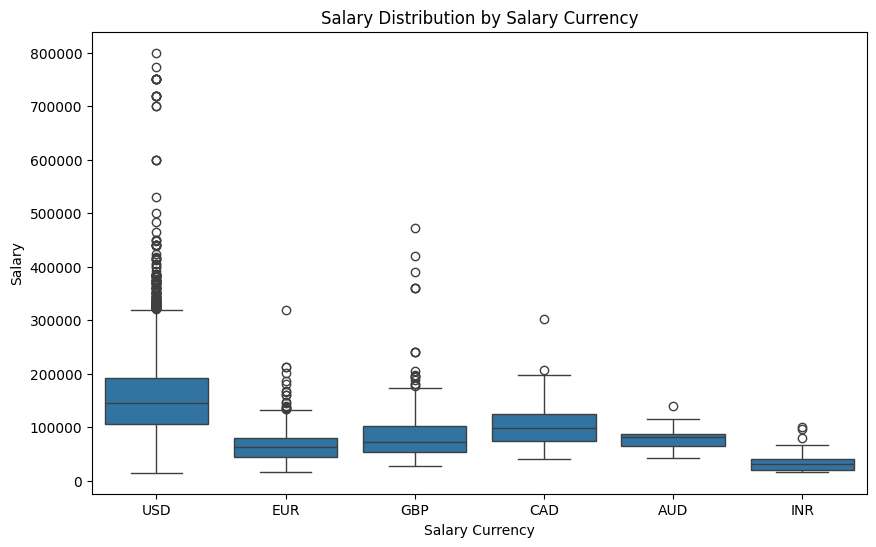

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Salary_Currency', y='Salary_in_USD', data=df_filtered, order=currencies)
plt.title('Salary Distribution by Salary Currency')
plt.xlabel('Salary Currency')
plt.ylabel('Salary')
plt.show()

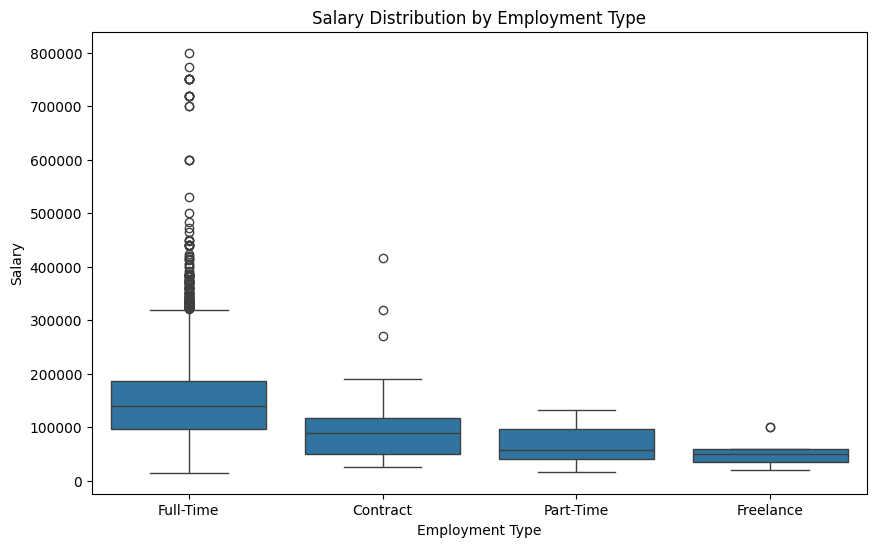

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Employment_Type', y='Salary_in_USD', data=df_filtered, order=df_filtered['Employment_Type'].unique())
plt.title('Salary Distribution by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Salary')
plt.show()

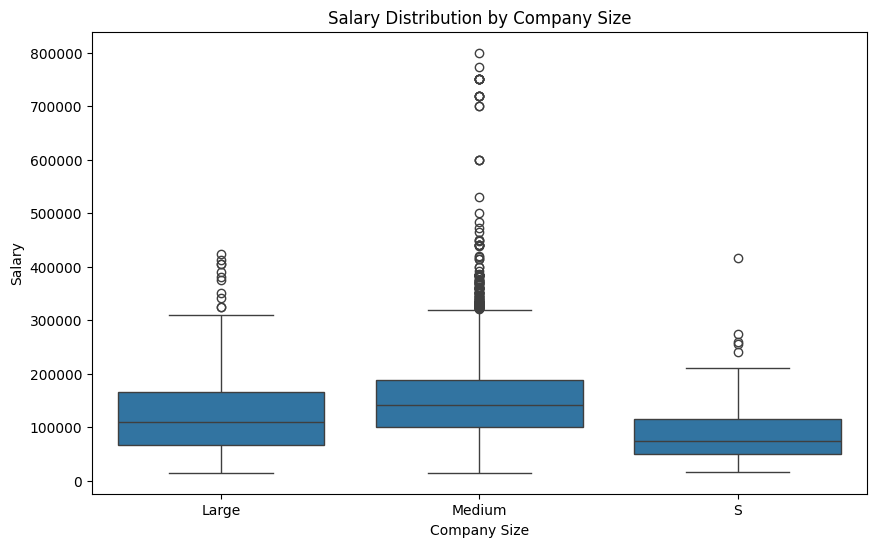

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Company_Size', y='Salary_in_USD', data=df_filtered, order=df_filtered['Company_Size'].unique())
plt.title('Salary Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Salary')
plt.show()

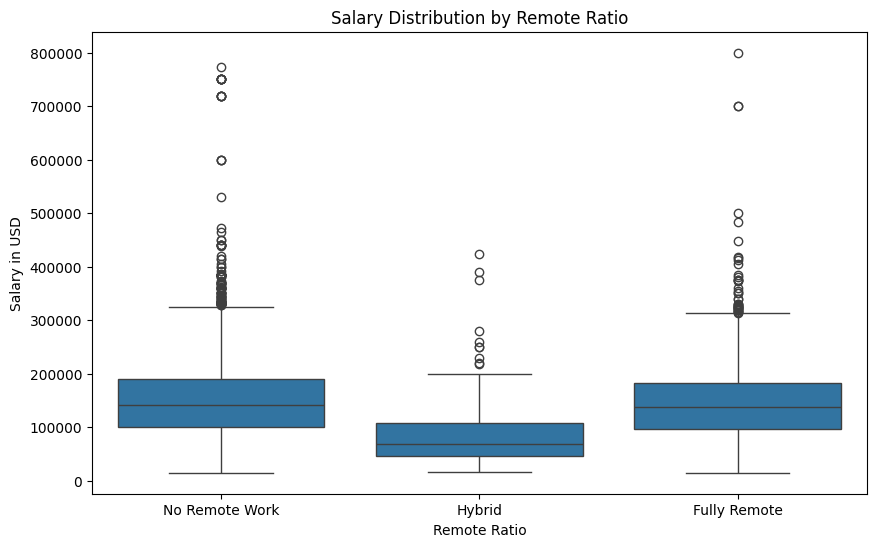

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Remote_Ratio', y='Salary_in_USD', data=df_filtered)
plt.title('Salary Distribution by Remote Ratio')
plt.xlabel('Remote Ratio')
plt.ylabel('Salary in USD')
plt.xticks(ticks=[0, 1, 2], labels=['No Remote Work', 'Hybrid', 'Fully Remote'])
plt.show()

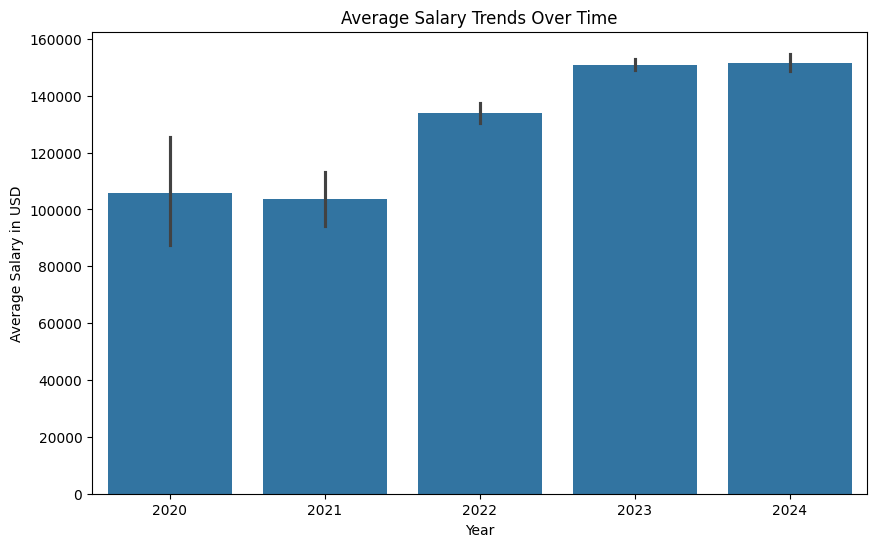

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Work_Year', y='Salary_in_USD', data=df_filtered, estimator='mean')
plt.title('Average Salary Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Salary in USD')
plt.show()

In [16]:
df_copy = df_filtered.copy(deep= True)
def label_to_numerical(df,col_names):
    for col_name in col_names:
        df[col_name] =df[col_name].map({label:i for i,label in enumerate(df[col_name].unique())})
    return df

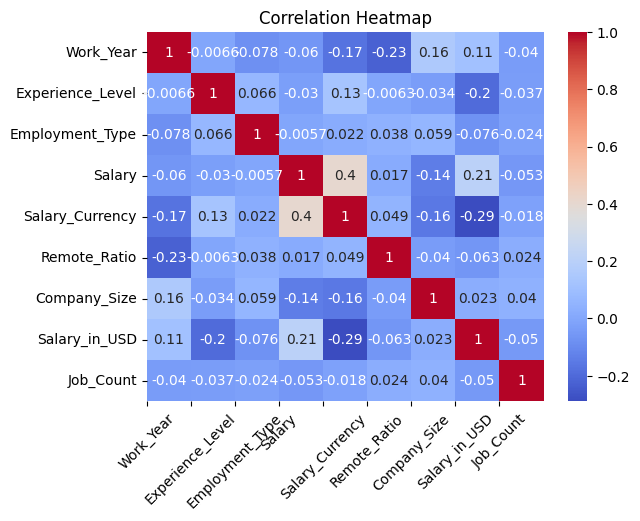

In [17]:
df_copy=label_to_numerical(df_copy,['Experience_Level','Employment_Type','Salary_Currency','Company_Size'])
def add_frequency_col(row):
    job_title=row['Job_Title']
    frequency = df_copy['Job_Title'].value_counts()[job_title]
    return frequency
df_copy['Job_Count']=df_copy.apply(add_frequency_col,axis=1)
numerical_cols = df_copy.select_dtypes(include=[np.number])
correlation = numerical_cols.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.xticks(range(len(correlation.columns)), correlation.columns, rotation= 45)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
X_copy = df_copy[['Experience_Level', 'Remote_Ratio', 'Employment_Type','Salary_Currency','Company_Size','Work_Year']] 

poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X_copy)

In [ ]:
X = df_copy[['Experience_Level', 'Remote_Ratio', 'Employment_Type','Salary_Currency','Company_Size','Work_Year']] 
y = df_copy['Salary_in_USD']

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Mean Squared Error:", root_mean_squared_error(y_test, y_pred))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred))

In [18]:
model = ols('Salary_in_USD ~ C(Experience_Level)', data=df_filtered).fit()

anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                           sum_sq      df           F         PR(>F)
C(Experience_Level)  5.826032e+12     3.0  419.505043  7.254552e-254
Residual             3.868235e+13  8356.0         NaN            NaN


In [25]:
model = ols('Salary_in_USD ~ C(Employment_Type)', data=df_filtered).fit()

anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                          sum_sq      df          F        PR(>F)
C(Employment_Type)  2.617009e+11     3.0  16.474096  1.137346e-10
Residual            4.424668e+13  8356.0        NaN           NaN


In [26]:
model = ols('Salary_in_USD ~ C(Remote_Ratio)', data=df_filtered).fit()

anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                       sum_sq      df          F        PR(>F)
C(Remote_Ratio)  1.005293e+12     2.0  96.559035  3.484461e-42
Residual         4.350309e+13  8357.0        NaN           NaN


In [27]:
model = ols('Salary_in_USD ~ C(Salary_Currency)', data=df_filtered).fit()

anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                          sum_sq      df          F         PR(>F)
C(Salary_Currency)  4.987929e+12     5.0  210.87388  1.849391e-212
Residual            3.952046e+13  8354.0        NaN            NaN


In [28]:
model = ols('Salary_in_USD ~ C(Work_Year)', data=df_filtered).fit()

anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                    sum_sq      df          F        PR(>F)
C(Work_Year)  8.123225e+11     4.0  38.830469  2.949967e-32
Residual      4.369606e+13  8355.0        NaN           NaN


In [29]:
tukey = pairwise_tukeyhsd(endog=df_filtered['Salary_in_USD'], groups=df_filtered['Experience_Level'], alpha=0.05)
print(tukey.summary())


              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1          group2       meandiff  p-adj    lower       upper    reject
--------------------------------------------------------------------------------
    Entry-Level Executive-Level 103001.9993   0.0  91461.9324 114542.0661   True
    Entry-Level       Mid-Level  34291.5838   0.0  27064.8491  41518.3185   True
    Entry-Level    Senior-Level  73807.0439   0.0  67125.3756  80488.7121   True
Executive-Level       Mid-Level -68710.4155   0.0 -79117.6802 -58303.1508   True
Executive-Level    Senior-Level -29194.9554   0.0 -39231.3967 -19158.5141   True
      Mid-Level    Senior-Level  39515.4601   0.0  35067.6846  43963.2355   True
--------------------------------------------------------------------------------


In [30]:
tukey = pairwise_tukeyhsd(endog=df_filtered['Salary_in_USD'], groups=df_filtered['Work_Year'], alpha=0.05)
print(tukey.summary())


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
  2020   2021 -2197.4478 0.9995 -29419.9309 25025.0352  False
  2020   2022 28204.7381 0.0127   4036.9362   52372.54   True
  2020   2023 45238.7708    0.0  21637.6853 68839.8563   True
  2020   2024 45937.2637    0.0  22192.1374 69682.3899   True
  2021   2022 30402.1859    0.0  15286.6076 45517.7643   True
  2021   2023 47436.2186    0.0  33244.3444 61628.0929   True
  2021   2024 48134.7115    0.0  33704.5666 62564.8564   True
  2022   2023 17034.0327    0.0  10368.5726 23699.4928   True
  2022   2024 17732.5256    0.0  10573.7446 24891.3066   True
  2023   2024   698.4929 0.9952  -4218.4911  5615.4768  False
-------------------------------------------------------------


In [31]:
tukey = pairwise_tukeyhsd(endog=df_filtered['Salary_in_USD'], groups=df_filtered['Remote_Ratio'], alpha=0.05)
print(tukey.summary())


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
     0     50 -67199.8744   0.0 -78946.0777 -55453.671   True
     0    100  -8700.4929   0.0 -12589.3076 -4811.6783   True
    50    100  58499.3814   0.0  46582.8869  70415.876   True
-------------------------------------------------------------


In [32]:
tukey = pairwise_tukeyhsd(endog=df_filtered['Salary_in_USD'], groups=df_filtered['Employment_Type'], alpha=0.05)
print(tukey.summary())


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
  group1    group2    meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------------
 Contract Freelance  -59670.867 0.0903 -125336.5161   5994.7821  False
 Contract Full-Time  36093.6419 0.0637   -1358.8538  73546.1376  False
 Contract Part-Time -43577.5421 0.2004 -100486.0947  13331.0105  False
Freelance Full-Time  95764.5089    0.0   41748.6913 149780.3265   True
Freelance Part-Time  16093.3249 0.9321   -52853.049  85039.6988  False
Full-Time Part-Time  -79671.184    0.0 -122616.6662 -36725.7018   True
----------------------------------------------------------------------


In [33]:
tukey = pairwise_tukeyhsd(endog=df_filtered['Salary_in_USD'], groups=df_filtered['Salary_Currency'], alpha=0.05)
print(tukey.summary())


      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
   AUD    CAD  27500.3024 0.8177  -35774.2545  90774.8593  False
   AUD    EUR -12943.4932 0.9879  -70530.9388  44643.9525  False
   AUD    GBP   4282.8835 0.9999  -53133.8397  61699.6067  False
   AUD    INR -46022.0575 0.2929 -108808.0005  16763.8854  False
   AUD    USD   74475.604 0.0025   17835.8563 131115.3517   True
   CAD    EUR -40443.7956 0.0019  -70678.0834 -10209.5077   True
   CAD    GBP -23217.4189 0.2318  -53125.2501   6690.4123  False
   CAD    INR -73522.3599    0.0 -112763.5743 -34281.1456   True
   CAD    USD  46975.3016    0.0   18587.6407  75362.9625   True
   EUR    GBP  17226.3766 0.0085    2834.6182  31618.1351   True
   EUR    INR -33078.5644 0.0158  -62276.4624  -3880.6664   True
   EUR    USD  87419.0972    0.0   76533.1598  98305.0346   True
   GBP    INR  -50304.941